# X-Ray Classification Machine Learning Final Project
- Jack Wagner, Zach Bingaman



In [1]:
#!pip3 install pydicom

In [37]:
import sklearn
import pydicom
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

In [3]:
test_files = glob('test/test/test/*/*/*/*')
train_files = glob('train/train/train/*/*/*/*')
label_dict = pd.read_csv('train.csv',index_col='SOPInstanceUID').to_dict()['Target']
label_dict

{'1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258': '0 ',
 '1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125': '15 ',
 '1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162': '12 ',
 '1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257': '14 ',
 '1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016': '3 ',
 '1.2.826.0.1.3680043.8.498.10053755320637729867508668285241208441': '3 ',
 '1.2.826.0.1.3680043.8.498.10062189329714053601496804394945741428': '14 ',
 '1.2.826.0.1.3680043.8.498.10065930002825553435161793347987832017': '13 20 ',
 '1.2.826.0.1.3680043.8.498.10072001800484199846734151421006166369': '3 ',
 '1.2.826.0.1.3680043.8.498.10077219503857952412254959562456136784': '3 ',
 '1.2.826.0.1.3680043.8.498.10080310665124574896848143784790467773': '3 ',
 '1.2.826.0.1.3680043.8.498.10089082474655893722076446314877509447': '14 ',
 '1.2.826.0.1.3680043.8.498.10092177056782233773275902757764299181': '3 ',
 '1.2.826.0.1.36

In [4]:
len(test_files),len(train_files)

(743, 1738)

In [5]:
for _file in train_files[:5]:
	print(_file)

train/train/train/797/1.2.826.0.1.3680043.8.498.90747964291383519207180054786456449991/1.2.826.0.1.3680043.8.498.34720289815233512582240808473743313270/1.2.826.0.1.3680043.8.498.21199751632414178657230526938620391906-c.dcm
train/train/train/797/1.2.826.0.1.3680043.8.498.90747964291383519207180054786456449991/1.2.826.0.1.3680043.8.498.80938952135029113721203363772854114837/1.2.826.0.1.3680043.8.498.11592311198629503991670907181209693809-c.dcm
train/train/train/909/1.2.826.0.1.3680043.8.498.20148265387596623458385742336274368844/1.2.826.0.1.3680043.8.498.34444291445575603060190925511237381164/1.2.826.0.1.3680043.8.498.71446631430051241458602990266940324877-c.dcm
train/train/train/909/1.2.826.0.1.3680043.8.498.20148265387596623458385742336274368844/1.2.826.0.1.3680043.8.498.32642454180637469235801371849340813159/1.2.826.0.1.3680043.8.498.88055284861184854928693676616485224405-c.dcm
train/train/train/909/1.2.826.0.1.3680043.8.498.20148265387596623458385742336274368844/1.2.826.0.1.3680043.8

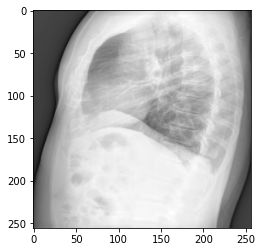

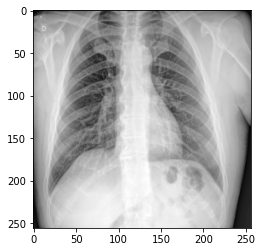

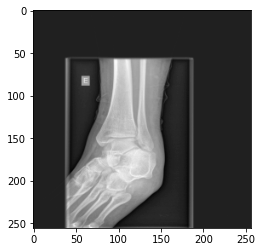

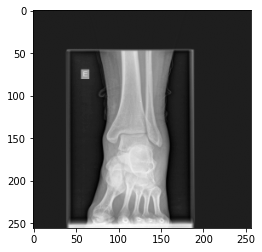

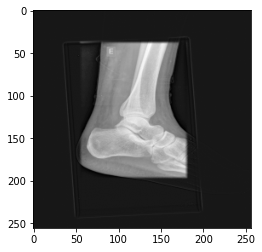

In [6]:
for _file in train_files[:5]:
    plt.figure()
    plt.imshow(pydicom.dcmread(_file).pixel_array, cmap='gray_r')
    plt.show()

In [7]:
pydicom.dcmread(train_files[0]).pixel_array.shape

(256, 256)

In [45]:
lst = [pydicom.dcmread(file).SOPInstanceUID for file in train_files]
	

In [47]:



img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in train_files])
data = pd.DataFrame(index=lst, data=img_pixels)

# for file in train_files[:300]:
	
# 	data = data.append(pd.DataFrame(pydicom.dcmread(file).pixel_array.flatten()).T)
# 	# data.add(label_dict[pydicom.dcmread(file).SOPInstanceUID])
# 	# ['label'] = 


In [9]:
data.reset_index(drop=True, inplace=True)

In [50]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
count,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,...,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000
mean,21720.472382,21807.159379,21848.576525,21860.108170,21847.455696,21825.678366,21804.130610,21789.976410,21768.247411,21751.636939,...,20992.979287,21043.203682,21081.831415,21123.158228,21159.017837,21190.861335,21220.403913,21217.591484,21217.334868,21153.932106
std,5729.751614,5685.364193,5671.254487,5679.095227,5674.698736,5677.242048,5680.895961,5687.383889,5701.970295,5706.543385,...,5984.207546,5965.917583,5958.316330,5939.828064,5923.464295,5911.985765,5909.426056,5911.942411,5922.586545,5968.957448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22015.000000,22082.500000,22227.750000,22246.750000,22268.500000,22252.500000,22181.750000,22087.750000,22015.000000,21927.250000,...,19589.500000,19934.750000,20149.500000,20252.500000,20425.500000,20531.250000,20625.250000,20652.500000,20612.500000,20438.500000
50%,24271.500000,24332.500000,24380.000000,24421.000000,24397.000000,24365.000000,24365.500000,24380.500000,24364.500000,24356.000000,...,24092.000000,24081.000000,24102.500000,24125.000000,24094.500000,24107.000000,24183.000000,24131.500000,24134.000000,24159.000000
75%,24570.750000,24578.000000,24578.000000,24578.750000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,...,24569.750000,24571.000000,24569.000000,24571.000000,24569.000000,24566.000000,24567.000000,24568.000000,24568.000000,24553.750000
max,26826.000000,26640.000000,27332.000000,26803.000000,26890.000000,27107.000000,27123.000000,27024.000000,27014.000000,26842.000000,...,26236.000000,26264.000000,26141.000000,26075.000000,26220.000000,26206.000000,26275.000000,26193.000000,25840.000000,27071.000000
